# ROI PREDICTION USING LGBM 

This notebook is majorly divided into three major components which is Data Cleaning and Feature Extraction, training the model, and Prediction on Test. 

**To run this on private dataset:** Go to cell 2 and enter the location of the test file in pd.readcsv() =>

test_all_loan=pd.readcsv({""location of test_main_all file""})

test_main_loan=pd.readcsv({"location of test_main_loan file"})

**Please save the training dataset also as I will be needed. I could have save the model using json but nothing was specified about it so it didnt.**

The training of model will take 10-15 minutes.

And run the file. I have already ran the hyperparameter tuning cell and parameters are already hypertuned.
So I have commented that.

You will get the submission file with name "submission.csv" in the directory

Importing libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error
import datetime

import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

import pandas as pd
from scipy.stats import zscore

from sklearn.preprocessing import MinMaxScaler,StandardScaler

Reading data using pandas

In [2]:
train_all_loan=pd.read_csv("dataset/train_all_loan.csv")
train_main_loan=pd.read_csv("dataset/train_main_loan.csv")

test_all_loan=pd.read_csv("dataset/test_all_loan.csv")
test_main_loan=pd.read_csv("dataset/test_main_loan.csv")

train_main_loan = train_main_loan[train_main_loan["ACTUAL_ROI"] != 0]

In [3]:
train_main_loan.columns

Index(['ID', 'ACCOUNT_TYPE', 'HIGH_CREDIT_OR_SANCTIONED_AMOUNT', 'DATE_OPENED',
       'CURRENT_BALANCE', 'ACTUAL_PAYMT_AMT', 'EMI_AMOUNT', 'REPAYMENT_TENURE',
       'LOAN_CLASSIFICATION', 'AMOUNT_OVERDUE', 'PAYMENT_HISTORY_1',
       'PAYMENT_HISTORY_2', 'OWNERSHIP_TYPE', 'COLLATERALVALUE', 'TU_SCORE',
       'PAYMENT_HISTORY_START_DATE', 'PAYMENT_HISTORY_END_DATE',
       'DATE_REPORTED_AND_CERTIFIED', 'DATE_OF_LAST_PAYMENT', 'Reported_Date',
       'DATE_OF_BIRTH', 'OCCUPATION_TYPE', 'GENDER', 'ACTUAL_ROI'],
      dtype='object')

In [4]:
train_all_loan.columns

Index(['ID', 'ACCOUNT_TYPE', 'HIGH_CREDIT_OR_SANCTIONED_AMOUNT', 'DATE_OPENED',
       'DATE_CLOSED', 'CURRENT_BALANCE', 'ACTUAL_PAYMT_AMT', 'EMI_AMOUNT',
       'REPAYMENT_TENURE', 'AMOUNT_OVERDUE', 'PAYMENT_HISTORY_1',
       'PAYMENT_HISTORY_2', 'OWNERSHIP_TYPE', 'COLLATERALVALUE', 'TU_SCORE',
       'PAYMENT_HISTORY_START_DATE', 'PAYMENT_HISTORY_END_DATE',
       'DATE_REPORTED_AND_CERTIFIED', 'DATE_OF_LAST_PAYMENT'],
      dtype='object')

In [5]:
train_main_loan.isna().sum()

ID                                      0
ACCOUNT_TYPE                            0
HIGH_CREDIT_OR_SANCTIONED_AMOUNT        0
DATE_OPENED                             0
CURRENT_BALANCE                         0
ACTUAL_PAYMT_AMT                     4215
EMI_AMOUNT                          49760
REPAYMENT_TENURE                    37174
LOAN_CLASSIFICATION                     0
AMOUNT_OVERDUE                      60084
PAYMENT_HISTORY_1                       0
PAYMENT_HISTORY_2                   39666
OWNERSHIP_TYPE                          0
COLLATERALVALUE                     22961
TU_SCORE                                0
PAYMENT_HISTORY_START_DATE              0
PAYMENT_HISTORY_END_DATE                0
DATE_REPORTED_AND_CERTIFIED             0
DATE_OF_LAST_PAYMENT                 3310
Reported_Date                           0
DATE_OF_BIRTH                           0
OCCUPATION_TYPE                     19108
GENDER                                  0
ACTUAL_ROI                        

In [6]:
train_all_loan.isna().sum()

ID                                        0
ACCOUNT_TYPE                              0
HIGH_CREDIT_OR_SANCTIONED_AMOUNT      25044
DATE_OPENED                             470
DATE_CLOSED                          376940
CURRENT_BALANCE                           0
ACTUAL_PAYMT_AMT                     794091
EMI_AMOUNT                           667217
REPAYMENT_TENURE                     605305
AMOUNT_OVERDUE                      1020818
PAYMENT_HISTORY_1                         0
PAYMENT_HISTORY_2                    695020
OWNERSHIP_TYPE                            0
COLLATERALVALUE                      959898
TU_SCORE                                  0
PAYMENT_HISTORY_START_DATE                0
PAYMENT_HISTORY_END_DATE                  0
DATE_REPORTED_AND_CERTIFIED               0
DATE_OF_LAST_PAYMENT                 164747
dtype: int64

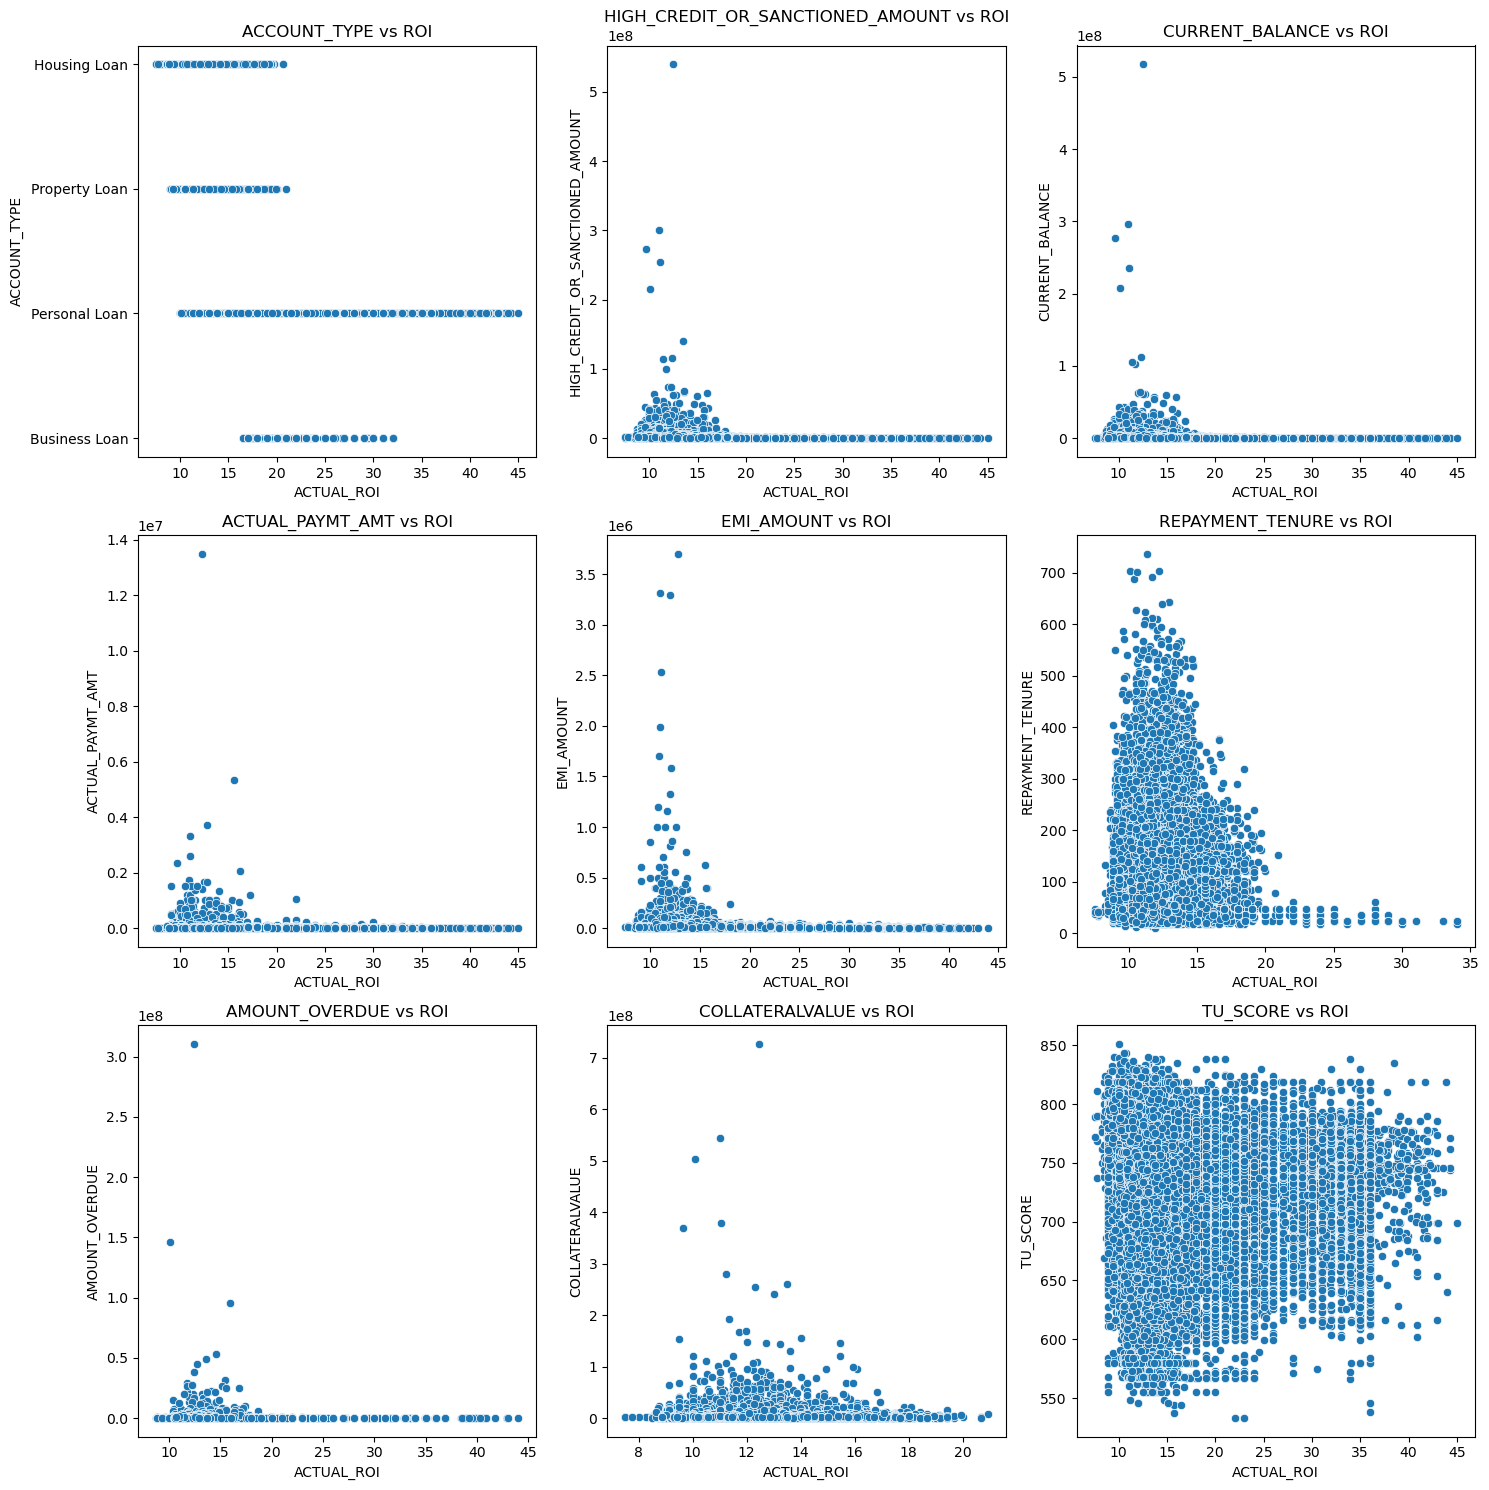

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `data` is your DataFrame containing the features and ROI
# Replace 'feature1', 'feature2', ..., with the actual column names from your dataset

# Set up the figure and axis for subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

# Define the features to plot against ROI
features = ['ACCOUNT_TYPE', 'HIGH_CREDIT_OR_SANCTIONED_AMOUNT', 'CURRENT_BALANCE',
            'ACTUAL_PAYMT_AMT', 'EMI_AMOUNT', 'REPAYMENT_TENURE',
            'AMOUNT_OVERDUE', 'COLLATERALVALUE', 'TU_SCORE']

# Plot each feature against ROI
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    sns.scatterplot(y=feature, x='ACTUAL_ROI', data=train_main_loan, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs ROI')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Data Cleaning and Feature Extraction

**In feature extraction, I tried not to use more than 20 features and using more than 20 can overfit the model**


Defining function calculate_average_days_past_due which extract features out of payment history

The purpose of the function calculate_average_days_past_due is to compute the average number of days past due based on the provided payment history string.

The function iterates over the payment history string, extracting each value representing the number of days past due. It skips over any values that are 'XXX', as they indicate that no data was reported for that month.

For each valid numeric value representing days past due, the function accumulates the total number of days past due and counts the number of months with valid data.

Once all valid numeric values have been processed, the function calculates the average days past due by dividing the total days past due by the number of months with valid data. If no valid data is available, it sets the average days past due to 0.

In [8]:
def calculate_average_past_due_days(payment_history):
    payment_history = payment_history.replace('XXX', '000')
    payment_history = payment_history.replace('STD', '000').replace('SMA', '060').replace('SUB', '090').replace('DBT', '090').replace('LSS', '090')
    if "X" not in payment_history:
        payment_history = int(float(payment_history))
        payment_history= '0' * (54 - len(str(payment_history))) + str(payment_history)
    past_due_days = [int(payment_history[i:i+3]) for i in range(3, len(payment_history), 3)]
    total_past_due_days = sum(past_due_days)
    average_past_due_days = total_past_due_days/36
    return average_past_due_days

Extracting features out of opening date as on the opening date the standard interest rate would effect the ROI for the customer
so extracting features like year, month, day , day_of_week from the opening date. 

In [9]:
def make_date_time_features(features):
    date_series1 = pd.to_datetime(features["DATE_OPENED"],format='%d-%m-%Y')
    features['year1'] = date_series1.dt.year
    features['month1'] = date_series1.dt.month
    features['day1'] = date_series1.dt.day
    features['day_of_week1'] = date_series1.dt.dayofweek

Following tells which features I have taken and also reason has been defined why I haven't took that feature.

**ID**: Not Taken, Not_relevant for training data

**ACCOUNT_TYPE:**  Taken

**HIGH_CREDIT_OR_SANCTIONED_AMOUNT:** Taken

**DATE_OPENED:** Indirectly taken, Relevant, extracted feature out of this in the form of date and time  

**CURRENT_BALANCE:** Taken

**ACTUAL_PAYMT_AMT:** Taken

**EMI_AMOUNT:** Taken, empty cells filled as (Sanctioned_loan_amount/Repayment_tenure)

**REPAYMENT_TENURE:** Taken Empty cell taken as Last_day_of_payment-date_openining

**LOAN_CLASSIFICATION:** Not taken, very low feature dependence                  

**AMOUNT_OVERDUE:** Taken, None cell taken as 0

**PAYMENT_HISTORY_:1** Taken 

**PAYMENT_HISTORY_2:** Not taken, contains many missing cells

**OWNERSHIP_TYPE:** Taken

**COLLATERALVALUE:** Taken, None cell taken as 0

**TU_SCORE:** Taken          

**PAYMENT_HISTORY_START_DATE:** Not taken, Not relevant

**PAYMENT_HISTORY_END_DATE:**   Not taken, Not relevant

**DATE_REPORTED_AND_CERTIFIED:** Not taken, doesnt want to exceed features more than 20

**DATE_OF_LAST_PAYMENT:** Not taken, doesnt want to exceed features more than 20

**Reported_Date:** Not taken, doesnt want to exceed features more than 20

**DATE_OF_BIRTH:**  Created age feature of it

**OCCUPATION_TYPE:** Taken 

**GENDER:** Not Taken very low feature dependence

Now there are are some features that I have made:

**Number_of_past_loans:** Number of past loan taken from train_all_loan

**Average_loan_amount_in_past:** Number of past loan amount taken from train_all_loan

**Average_Balance:** Average balance while past loan taken from train_all_loan

**total_month:** Total month between last day of payment and date opened

**age:** Age at the time of date_opened

**credit_utilization_ratio:** CURRENT_BALANCE/HIGH_CREDIT_OR_SANCTIONED_AMOUNT     

**assest_utilization_ratio:** HIGH_CREDIT_OR_SANCTIONED_AMOUNT/COLLATERALVALUE

**networth:** Total balance + collateral value earned per year in life

**Combined_category:** Occupation type and ownership type are combined 

Also there was many empty cell in Repayment_Tenure so I have filled those with number of month between opened date and reported date

Also there was many empty cell in Occupation type that is converted into categorical data.

Applied **standard scalar** to ['REPAYMENT_TENURE', 'TU_SCORE','HIGH_CREDIT_OR_SANCTIONED_AMOUNT', 'CURRENT_BALANCE', 'ACTUAL_PAYMT_AMT','COLLATERALVALUE', 'Number_of_past_loans', 'Average_loan_amount_in_past','Average_Balance', 'total_month', 'age', 'credit_utilization_ratio','assest_utilization_ratio', 'average_days_past_due',"networth"]

In [10]:
from sklearn.impute import KNNImputer
def data_cleaning(df,df_all):
    df["OCCUPATION_TYPE"]=df["OCCUPATION_TYPE"].fillna(0)
    df["COLLATERALVALUE"]=df["COLLATERALVALUE"].fillna(0)
    df["AMOUNT_OVERDUE"]=df["AMOUNT_OVERDUE"].fillna(0)
    df["DATE_OF_LAST_PAYMENT"].fillna(df["Reported_Date"],inplace=True)
    
    grouped = df_all.groupby('ID')['HIGH_CREDIT_OR_SANCTIONED_AMOUNT'].agg(['count', 'mean']).reset_index()
    df= pd.merge(df, grouped, on='ID', how='left')
    df.rename(columns={'count': "Number_of_past_loans", 'mean': 'Average_loan_amount_in_past'}, inplace=True)

    grouped_balance = df_all.groupby('ID')['CURRENT_BALANCE'].agg(["mean"]).reset_index()
    df = pd.merge(df, grouped_balance, on='ID', how='left')
    df.rename(columns={'mean': 'Average_Balance'}, inplace=True)
    
    df["DATE_OF_LAST_PAYMENT"]=pd.to_datetime(df["DATE_OF_LAST_PAYMENT"],format='%d-%m-%Y')
    df["DATE_OF_BIRTH"]=pd.to_datetime(df["DATE_OF_BIRTH"],format='%d-%m-%Y')
    df["Reported_Date"]=pd.to_datetime(df["Reported_Date"])
    df["DATE_OPENED"]=pd.to_datetime(df["DATE_OPENED"])
    difference =df["DATE_OF_LAST_PAYMENT"]-df["DATE_OPENED"]
    df["total_month"]=((difference.dt.days)//30.5)+1
    df["age"]=(df["DATE_OPENED"]-df["DATE_OF_BIRTH"]).dt.days
    
    df["networth"]=(df["COLLATERALVALUE"]+df["CURRENT_BALANCE"])/df["age"]
    
    df["credit_utilization_ratio"]=df["CURRENT_BALANCE"]/df["HIGH_CREDIT_OR_SANCTIONED_AMOUNT"]
    df["assest_utilization_ratio"]=df["COLLATERALVALUE"]/df["HIGH_CREDIT_OR_SANCTIONED_AMOUNT"]
    
#     df["left_after_paid"]=df["HIGH_CREDIT_OR_SANCTIONED_AMOUNT"]-df["CURRENT_BALANCE"]
    make_date_time_features(df)
    df['average_days_past_due'] = df['PAYMENT_HISTORY_1'].apply(calculate_average_past_due_days)
    
    df['REPAYMENT_TENURE']=df['REPAYMENT_TENURE'].fillna(df["total_month"])
    count=df["ACTUAL_PAYMT_AMT"].mean()
    df["ACTUAL_PAYMT_AMT"]=df["ACTUAL_PAYMT_AMT"].fillna(count)
    
    df["EMI_AMOUNT"]=df["EMI_AMOUNT"].fillna(df['HIGH_CREDIT_OR_SANCTIONED_AMOUNT']/df["REPAYMENT_TENURE"])
    

    df['Combined_category'] = df["OWNERSHIP_TYPE"].astype(str) + '_' + df["OCCUPATION_TYPE"].astype(str)
    df.drop(["OWNERSHIP_TYPE", "OCCUPATION_TYPE"], axis=1, inplace=True)
    df['Combined_category'] = df['Combined_category'].astype("category")
    df['Combined_category'] = df['Combined_category'].cat.codes
    
    
    df_train=df.drop(["PAYMENT_HISTORY_1","PAYMENT_HISTORY_2","DATE_OPENED","DATE_OF_BIRTH","DATE_OF_LAST_PAYMENT","PAYMENT_HISTORY_START_DATE","PAYMENT_HISTORY_END_DATE","DATE_REPORTED_AND_CERTIFIED","Reported_Date","year1","GENDER","LOAN_CLASSIFICATION","AMOUNT_OVERDUE"],axis=1)
    
    df_train["ACCOUNT_TYPE"] = df_train["ACCOUNT_TYPE"].astype("category")
#     df_train["OWNERSHIP_TYPE"] = df_train["OWNERSHIP_TYPE"].astype("category")
#     df_train["OCCUPATION_TYPE"] = df_train["OCCUPATION_TYPE"].astype("category")
#     df_train["GENDER"]=df_train["GENDER"].astype("category")

    df_train["ACCOUNT_TYPE"] = df_train["ACCOUNT_TYPE"].cat.codes
#     df_train["OWNERSHIP_TYPE"] = df_train["OWNERSHIP_TYPE"].cat.codes
#     df_train["OCCUPATION_TYPE"] = df_train["OCCUPATION_TYPE"].cat.codes
#     df_train["GENDER"]=df_train["GENDER"].cat.codes

#     min_max_features = ['HIGH_CREDIT_OR_SANCTIONED_AMOUNT', 'CURRENT_BALANCE', 'ACTUAL_PAYMT_AMT',
#                     'COLLATERALVALUE', 'Number_of_past_loans', 'Average_loan_amount_in_past',
#                     'Average_Balance', 'total_month', 'age', 'credit_utilization_ratio',"assest_utilization_ratio",
#                     'average_days_past_due',"networth","EMI_AMOUNT"]
#     min_max_scaler = MinMaxScaler()
#     df_train[min_max_features] = min_max_scaler.fit_transform(df_train[min_max_features])
    standardize_features = ['REPAYMENT_TENURE', 'TU_SCORE','HIGH_CREDIT_OR_SANCTIONED_AMOUNT', 'CURRENT_BALANCE', 'ACTUAL_PAYMT_AMT',
                    'COLLATERALVALUE', 'Number_of_past_loans', 'Average_loan_amount_in_past',
                    'Average_Balance', 'total_month', 'age', 'credit_utilization_ratio',"assest_utilization_ratio",
                    'average_days_past_due',"networth","EMI_AMOUNT"]
    standard_scaler = StandardScaler()
    df_train[standardize_features] = standard_scaler.fit_transform(df_train[standardize_features])

    return df_train



In [11]:
df_train=data_cleaning(train_main_loan,train_all_loan)

C:\Users\pranj\AppData\Local\Temp\ipykernel_9300\2285179569.py:18: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Reported_Date"]=pd.to_datetime(df["Reported_Date"])
C:\Users\pranj\AppData\Local\Temp\ipykernel_9300\2285179569.py:19: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DATE_OPENED"]=pd.to_datetime(df["DATE_OPENED"])


In [12]:
df_train.isna().sum()

ID                                  0
ACCOUNT_TYPE                        0
HIGH_CREDIT_OR_SANCTIONED_AMOUNT    0
CURRENT_BALANCE                     0
ACTUAL_PAYMT_AMT                    0
EMI_AMOUNT                          0
REPAYMENT_TENURE                    0
COLLATERALVALUE                     0
TU_SCORE                            0
ACTUAL_ROI                          0
Number_of_past_loans                0
Average_loan_amount_in_past         0
Average_Balance                     0
total_month                         0
age                                 0
networth                            0
credit_utilization_ratio            0
assest_utilization_ratio            0
month1                              0
day1                                0
day_of_week1                        0
average_days_past_due               0
Combined_category                   0
dtype: int64

In [13]:
df_train

,ID,ACCOUNT_TYPE,HIGH_CREDIT_OR_SANCTIONED_AMOUNT,CURRENT_BALANCE,ACTUAL_PAYMT_AMT,EMI_AMOUNT,REPAYMENT_TENURE,COLLATERALVALUE,TU_SCORE,ACTUAL_ROI,...,total_month,age,networth,credit_utilization_ratio,assest_utilization_ratio,month1,day1,day_of_week1,average_days_past_due,Combined_category
0,A002338349,1,-0.146691,-0.144332,-0.111097,-0.217905,0.593804,-0.048294,-1.196619,12.32,...,1.567669,0.464370,-0.115322,-0.102171,0.492108,6,13,4,-0.322228,8
1,A002000537,1,-0.030391,-0.053494,-0.227122,-0.211280,0.730867,-0.130419,0.901011,12.42,...,1.955413,-1.040004,-0.013702,-0.188938,-0.097496,12,5,2,-0.385381,8
2,A002421579,1,0.128964,0.048731,-0.005323,-0.204207,0.652545,0.175935,0.167859,10.87,...,0.835263,-0.783280,0.271823,-0.426956,0.229890,3,16,3,-0.385381,8
3,A002152345,1,0.134843,0.174498,0.151147,0.076739,-0.688719,0.095588,0.941742,10.00,...,-0.651090,1.503346,-0.010516,0.568620,0.088928,12,24,5,-0.385381,5
4,A001952834,1,0.263513,0.194119,0.124522,-0.196903,0.339257,0.056138,-1.542829,11.97,...,1.459962,0.155203,0.090529,-0.148217,-0.112546,10,21,1,2.286331,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69946,A000195582,3,0.340533,0.367877,0.204913,-0.176980,0.789609,2.079327,0.086398,12.97,...,0.576767,-0.935667,2.218239,0.492092,2.168253,3,15,3,3.853749,9
69947,A001735798,0,-0.092629,-0.100269,0.191907,-0.194713,-0.326479,-0.359770,-1.359541,18.00,...,-0.564925,-0.844784,-0.264153,-0.124111,-0.651831,8,26,4,-0.385381,5
69948,A002435973,0,-0.278799,-0.250157,-0.085956,-0.220933,-0.326479,-0.359770,-3.518267,21.00,...,-0.564925,-0.358519,-0.337715,0.143900,-0.651831,3,22,1,1.703678,5
69949,A000027755,1,0.062981,0.036486,0.004714,-0.213360,0.603594,1.059744,1.186126,12.07,...,1.223007,0.586554,0.608002,-0.061738,2.040156,9,12,5,-0.385381,8


## Training the model

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X=df_train.drop(["ACTUAL_ROI","ID"],axis=1)
y=df_train["ACTUAL_ROI"]


I have used LGBM model which is a boosting algorithm.

It is also an esemble model, Ii help in encountering sparse data.

In LGBM I have used K-fold validation so that my model do not overfit on the training data

Metric is RMSE as given

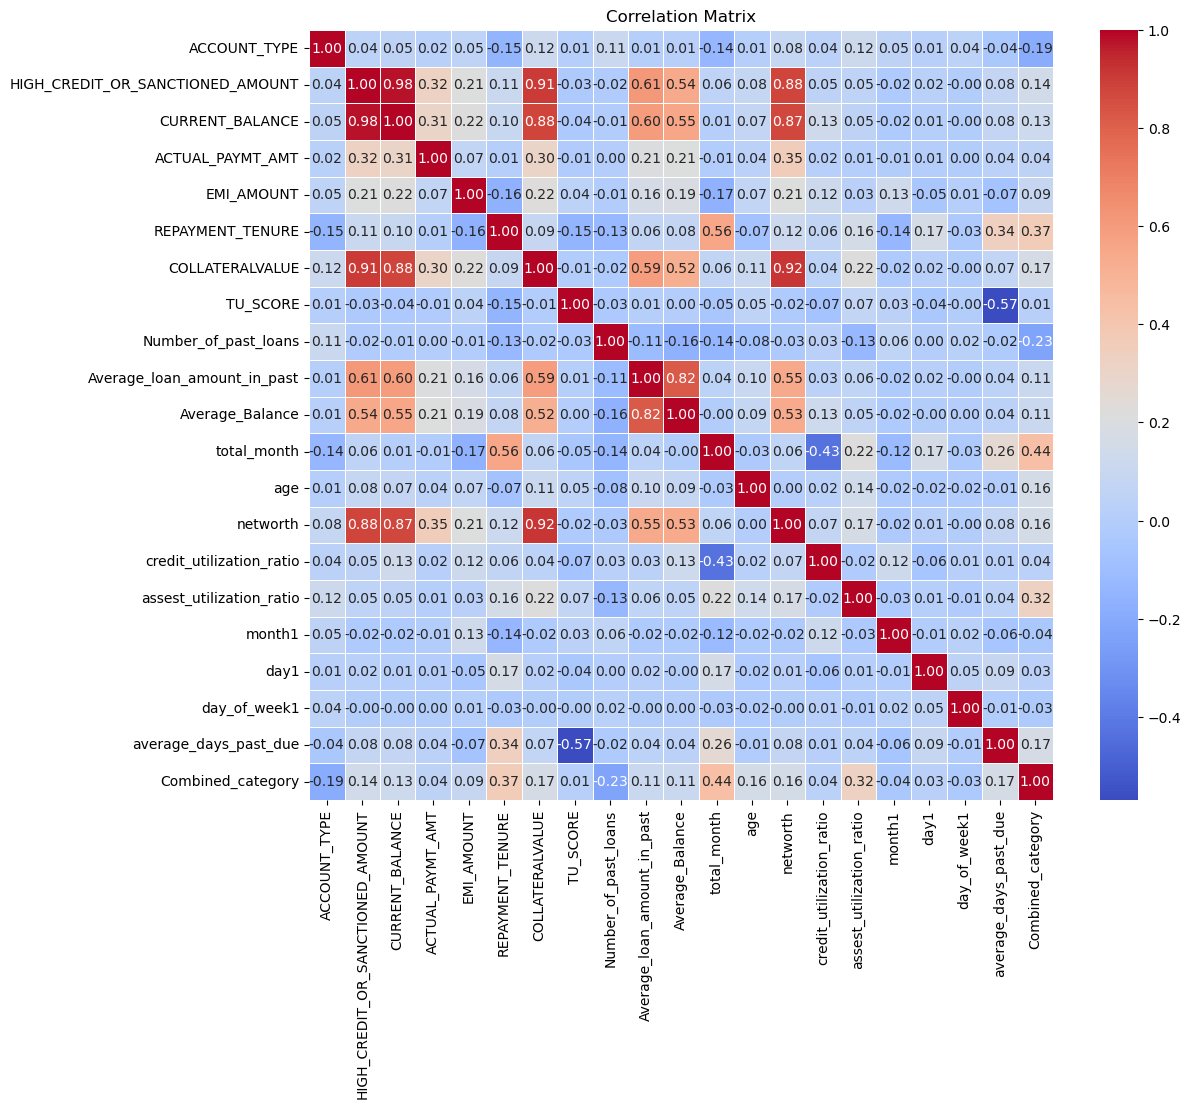

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
correlation_matrix = X.corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [16]:
X

,ACCOUNT_TYPE,HIGH_CREDIT_OR_SANCTIONED_AMOUNT,CURRENT_BALANCE,ACTUAL_PAYMT_AMT,EMI_AMOUNT,REPAYMENT_TENURE,COLLATERALVALUE,TU_SCORE,Number_of_past_loans,Average_loan_amount_in_past,...,total_month,age,networth,credit_utilization_ratio,assest_utilization_ratio,month1,day1,day_of_week1,average_days_past_due,Combined_category
0,1,-0.146691,-0.144332,-0.111097,-0.217905,0.593804,-0.048294,-1.196619,0.248544,-0.303296,...,1.567669,0.464370,-0.115322,-0.102171,0.492108,6,13,4,-0.322228,8
1,1,-0.030391,-0.053494,-0.227122,-0.211280,0.730867,-0.130419,0.901011,-0.576820,-0.132894,...,1.955413,-1.040004,-0.013702,-0.188938,-0.097496,12,5,2,-0.385381,8
2,1,0.128964,0.048731,-0.005323,-0.204207,0.652545,0.175935,0.167859,-0.139863,-0.032762,...,0.835263,-0.783280,0.271823,-0.426956,0.229890,3,16,3,-0.385381,8
3,1,0.134843,0.174498,0.151147,0.076739,-0.688719,0.095588,0.941742,0.005790,-0.121196,...,-0.651090,1.503346,-0.010516,0.568620,0.088928,12,24,5,-0.385381,5
4,1,0.263513,0.194119,0.124522,-0.196903,0.339257,0.056138,-1.542829,-0.528269,0.258517,...,1.459962,0.155203,0.090529,-0.148217,-0.112546,10,21,1,2.286331,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69946,3,0.340533,0.367877,0.204913,-0.176980,0.789609,2.079327,0.086398,-0.382617,0.416303,...,0.576767,-0.935667,2.218239,0.492092,2.168253,3,15,3,3.853749,9
69947,0,-0.092629,-0.100269,0.191907,-0.194713,-0.326479,-0.359770,-1.359541,0.151442,-0.295691,...,-0.564925,-0.844784,-0.264153,-0.124111,-0.651831,8,26,4,-0.385381,5
69948,0,-0.278799,-0.250157,-0.085956,-0.220933,-0.326479,-0.359770,-3.518267,-0.673922,-0.184105,...,-0.564925,-0.358519,-0.337715,0.143900,-0.651831,3,22,1,1.703678,5
69949,1,0.062981,0.036486,0.004714,-0.213360,0.603594,1.059744,1.186126,-0.576820,0.831039,...,1.223007,0.586554,0.608002,-0.061738,2.040156,9,12,5,-0.385381,8


In [17]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Setting parameters for the LightGBM model with RMSE metric
params = {
    "n_estimators":2000,
    'boosting_type': 'gbdt',
    'num_leaves': 256,
    'learning_rate': 0.020,
    'feature_fraction': 0.8,
    'metric': "rmse",
    "verbosity": -1,
    "importance_type": "gain",
    "reg_alpha": 0.1,
    "reg_lambda": 0.1
}

# Number of folds for cross-validation
num_folds = 10

# Initializing KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initializing arrays to store predictions and true labels for both training and validation sets
train_predictions = np.zeros(len(X))
train_true_labels = np.zeros(len(X))
val_predictions = np.zeros(len(X))
val_true_labels = np.zeros(len(X))

# Initializing arrays to store feature importance scores
feature_importance = np.zeros(X.shape[1])

# Performing 10-fold cross-validation
for fold, (train_index, valid_index) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    # Creating LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

    # Training the LightGBM model
    model_lgbm = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[train_data, valid_data],
                      callbacks=[lgb.callback.early_stopping(stopping_rounds=50),
                                lgb.callback.log_evaluation(period=100)])

    # Making predictions on the training set
    train_pred = model_lgbm.predict(X_train, num_iteration=model_lgbm.best_iteration)
    train_predictions[train_index] = train_pred
    train_true_labels[train_index] = y_train

    # Making predictions on the validation set
    valid_pred = model_lgbm.predict(X_valid, num_iteration=model_lgbm.best_iteration)
    val_predictions[valid_index] = valid_pred
    val_true_labels[valid_index] = y_valid

    # Accumulating feature importance scores
    feature_importance += model_lgbm.feature_importance(importance_type='gain') / num_folds

# Calculate RMSE for validation set
val_rmse = np.sqrt(mean_squared_error(val_predictions, val_true_labels))
print("Validation Set RMSE:", val_rmse)

# Calculate r value for validation set
val_r_value = np.corrcoef(val_predictions, val_true_labels)[0, 1]
print("Validation Set r value:", val_r_value)

# Calculate RMSE for training set
train_rmse = np.sqrt(mean_squared_error(train_predictions, train_true_labels))
print("Training Set RMSE:", train_rmse)

# Calculate r value for training set
train_r_value = np.corrcoef(train_predictions, train_true_labels)[0, 1]
print("Training Set r value:", train_r_value)

# Print feature importance scores
print("Feature Importance:")
for i, col in enumerate(X.columns):
    print(f"{col}: {feature_importance[i]}")


Fold 1/10
Training until validation scores don't improve for 50 rounds


C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.2158	valid_1's rmse: 2.4904
[200]	training's rmse: 1.71049	valid_1's rmse: 2.2044
[300]	training's rmse: 1.52883	valid_1's rmse: 2.15388
[400]	training's rmse: 1.3994	valid_1's rmse: 2.12882
[500]	training's rmse: 1.30271	valid_1's rmse: 2.11538
[600]	training's rmse: 1.22964	valid_1's rmse: 2.10453
[700]	training's rmse: 1.15867	valid_1's rmse: 2.09788
[800]	training's rmse: 1.09939	valid_1's rmse: 2.09111
[900]	training's rmse: 1.04886	valid_1's rmse: 2.08704
[1000]	training's rmse: 0.998832	valid_1's rmse: 2.08341
[1100]	training's rmse: 0.950684	valid_1's rmse: 2.08059
[1200]	training's rmse: 0.906941	valid_1's rmse: 2.07938
[1300]	training's rmse: 0.864833	valid_1's rmse: 2.07665
[1400]	training's rmse: 0.824891	valid_1's rmse: 2.07484
[1500]	training's rmse: 0.788898	valid_1's rmse: 2.07285
[1600]	training's rmse: 0.753025	valid_1's rmse: 2.07079
[1700]	training's rmse: 0.72199	valid_1's rmse: 2.06932
[1800]	training's rmse: 0.693552	valid_1's rmse: 2.068

C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.21899	valid_1's rmse: 2.38469
[200]	training's rmse: 1.71309	valid_1's rmse: 2.12433
[300]	training's rmse: 1.52361	valid_1's rmse: 2.08224
[400]	training's rmse: 1.39668	valid_1's rmse: 2.06904
[500]	training's rmse: 1.30358	valid_1's rmse: 2.06378
[600]	training's rmse: 1.22776	valid_1's rmse: 2.0558
[700]	training's rmse: 1.16283	valid_1's rmse: 2.04892
[800]	training's rmse: 1.10587	valid_1's rmse: 2.04479
[900]	training's rmse: 1.05629	valid_1's rmse: 2.04276
Early stopping, best iteration is:
[892]	training's rmse: 1.06099	valid_1's rmse: 2.04261
Fold 3/10
Training until validation scores don't improve for 50 rounds


C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.21104	valid_1's rmse: 2.50049
[200]	training's rmse: 1.70561	valid_1's rmse: 2.21323
[300]	training's rmse: 1.51946	valid_1's rmse: 2.16431
[400]	training's rmse: 1.39281	valid_1's rmse: 2.1436
[500]	training's rmse: 1.30554	valid_1's rmse: 2.12873
[600]	training's rmse: 1.23105	valid_1's rmse: 2.11859
[700]	training's rmse: 1.16402	valid_1's rmse: 2.11122
[800]	training's rmse: 1.10971	valid_1's rmse: 2.10589
[900]	training's rmse: 1.04932	valid_1's rmse: 2.10199
[1000]	training's rmse: 0.997246	valid_1's rmse: 2.09904
[1100]	training's rmse: 0.948874	valid_1's rmse: 2.09462
[1200]	training's rmse: 0.904978	valid_1's rmse: 2.09192
[1300]	training's rmse: 0.863477	valid_1's rmse: 2.08966
[1400]	training's rmse: 0.824502	valid_1's rmse: 2.08734
[1500]	training's rmse: 0.788611	valid_1's rmse: 2.08559
[1600]	training's rmse: 0.754699	valid_1's rmse: 2.08367
[1700]	training's rmse: 0.724614	valid_1's rmse: 2.08249
[1800]	training's rmse: 0.697997	valid_1's rmse: 2

C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.21108	valid_1's rmse: 2.5373
[200]	training's rmse: 1.70542	valid_1's rmse: 2.24972
[300]	training's rmse: 1.52278	valid_1's rmse: 2.20029
[400]	training's rmse: 1.39711	valid_1's rmse: 2.18211
[500]	training's rmse: 1.29955	valid_1's rmse: 2.17133
[600]	training's rmse: 1.22123	valid_1's rmse: 2.16213
[700]	training's rmse: 1.15696	valid_1's rmse: 2.15442
[800]	training's rmse: 1.09611	valid_1's rmse: 2.14757
[900]	training's rmse: 1.04353	valid_1's rmse: 2.14495
[1000]	training's rmse: 0.991888	valid_1's rmse: 2.14235
[1100]	training's rmse: 0.937837	valid_1's rmse: 2.1392
[1200]	training's rmse: 0.899304	valid_1's rmse: 2.13713
[1300]	training's rmse: 0.865007	valid_1's rmse: 2.13481
[1400]	training's rmse: 0.832506	valid_1's rmse: 2.13297
[1500]	training's rmse: 0.798056	valid_1's rmse: 2.13158
Early stopping, best iteration is:
[1540]	training's rmse: 0.784178	valid_1's rmse: 2.13134
Fold 5/10
Training until validation scores don't improve for 50 rounds


C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.21387	valid_1's rmse: 2.49734
[200]	training's rmse: 1.70431	valid_1's rmse: 2.21508
[300]	training's rmse: 1.5216	valid_1's rmse: 2.16682
[400]	training's rmse: 1.39475	valid_1's rmse: 2.14816
[500]	training's rmse: 1.29854	valid_1's rmse: 2.14173
[600]	training's rmse: 1.22336	valid_1's rmse: 2.13374
[700]	training's rmse: 1.15979	valid_1's rmse: 2.12814
[800]	training's rmse: 1.09962	valid_1's rmse: 2.12593
[900]	training's rmse: 1.04649	valid_1's rmse: 2.12372
[1000]	training's rmse: 0.999594	valid_1's rmse: 2.12108
[1100]	training's rmse: 0.954318	valid_1's rmse: 2.11839
[1200]	training's rmse: 0.912381	valid_1's rmse: 2.11643
[1300]	training's rmse: 0.874654	valid_1's rmse: 2.11468
[1400]	training's rmse: 0.839197	valid_1's rmse: 2.11383
[1500]	training's rmse: 0.802256	valid_1's rmse: 2.11229
[1600]	training's rmse: 0.769749	valid_1's rmse: 2.11127
[1700]	training's rmse: 0.734045	valid_1's rmse: 2.10985
Early stopping, best iteration is:
[1713]	training

C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.2123	valid_1's rmse: 2.51124
[200]	training's rmse: 1.70812	valid_1's rmse: 2.21358
[300]	training's rmse: 1.52672	valid_1's rmse: 2.16463
[400]	training's rmse: 1.40427	valid_1's rmse: 2.13922
[500]	training's rmse: 1.31739	valid_1's rmse: 2.12704
[600]	training's rmse: 1.24315	valid_1's rmse: 2.11792
[700]	training's rmse: 1.17368	valid_1's rmse: 2.11096
[800]	training's rmse: 1.11063	valid_1's rmse: 2.10614
[900]	training's rmse: 1.05573	valid_1's rmse: 2.10024
[1000]	training's rmse: 1.00373	valid_1's rmse: 2.09517
[1100]	training's rmse: 0.956234	valid_1's rmse: 2.09343
[1200]	training's rmse: 0.915445	valid_1's rmse: 2.09029
[1300]	training's rmse: 0.876087	valid_1's rmse: 2.08712
[1400]	training's rmse: 0.835057	valid_1's rmse: 2.08587
[1500]	training's rmse: 0.799343	valid_1's rmse: 2.08372
[1600]	training's rmse: 0.76449	valid_1's rmse: 2.08174
[1700]	training's rmse: 0.735281	valid_1's rmse: 2.07978
[1800]	training's rmse: 0.704649	valid_1's rmse: 2.0

C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.20885	valid_1's rmse: 2.53095
[200]	training's rmse: 1.70634	valid_1's rmse: 2.26562
[300]	training's rmse: 1.51892	valid_1's rmse: 2.22758
[400]	training's rmse: 1.39012	valid_1's rmse: 2.21633
[500]	training's rmse: 1.30122	valid_1's rmse: 2.20571
[600]	training's rmse: 1.22895	valid_1's rmse: 2.19856
[700]	training's rmse: 1.16679	valid_1's rmse: 2.19197
[800]	training's rmse: 1.1046	valid_1's rmse: 2.18867
[900]	training's rmse: 1.05098	valid_1's rmse: 2.18401
[1000]	training's rmse: 1.00368	valid_1's rmse: 2.18003
[1100]	training's rmse: 0.9572	valid_1's rmse: 2.17878
[1200]	training's rmse: 0.909699	valid_1's rmse: 2.17812
[1300]	training's rmse: 0.867281	valid_1's rmse: 2.1772
[1400]	training's rmse: 0.832732	valid_1's rmse: 2.17575
[1500]	training's rmse: 0.794825	valid_1's rmse: 2.17496
Early stopping, best iteration is:
[1471]	training's rmse: 0.805838	valid_1's rmse: 2.1744
Fold 8/10
Training until validation scores don't improve for 50 rounds


C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.21184	valid_1's rmse: 2.4922
[200]	training's rmse: 1.70979	valid_1's rmse: 2.21422
[300]	training's rmse: 1.52843	valid_1's rmse: 2.17082
[400]	training's rmse: 1.39919	valid_1's rmse: 2.15393
[500]	training's rmse: 1.30614	valid_1's rmse: 2.14211
[600]	training's rmse: 1.22947	valid_1's rmse: 2.13342
[700]	training's rmse: 1.1655	valid_1's rmse: 2.12787
[800]	training's rmse: 1.10831	valid_1's rmse: 2.12432
[900]	training's rmse: 1.05525	valid_1's rmse: 2.12092
[1000]	training's rmse: 1.00788	valid_1's rmse: 2.11817
[1100]	training's rmse: 0.964482	valid_1's rmse: 2.11458
[1200]	training's rmse: 0.920077	valid_1's rmse: 2.11172
[1300]	training's rmse: 0.881291	valid_1's rmse: 2.11105
Early stopping, best iteration is:
[1265]	training's rmse: 0.895361	valid_1's rmse: 2.11047
Fold 9/10
Training until validation scores don't improve for 50 rounds


C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	training's rmse: 2.20604	valid_1's rmse: 2.50445
[200]	training's rmse: 1.70005	valid_1's rmse: 2.24838
[300]	training's rmse: 1.51831	valid_1's rmse: 2.20059
[400]	training's rmse: 1.38911	valid_1's rmse: 2.18473
[500]	training's rmse: 1.29611	valid_1's rmse: 2.17759
[600]	training's rmse: 1.21629	valid_1's rmse: 2.17239
[700]	training's rmse: 1.14818	valid_1's rmse: 2.16761
[800]	training's rmse: 1.09085	valid_1's rmse: 2.16353
[900]	training's rmse: 1.03934	valid_1's rmse: 2.16159
[1000]	training's rmse: 0.994791	valid_1's rmse: 2.15843
[1100]	training's rmse: 0.945846	valid_1's rmse: 2.15609
[1200]	training's rmse: 0.908882	valid_1's rmse: 2.1543
[1300]	training's rmse: 0.870805	valid_1's rmse: 2.15177
[1400]	training's rmse: 0.833842	valid_1's rmse: 2.15046
[1500]	training's rmse: 0.794686	valid_1's rmse: 2.14912
Early stopping, best iteration is:
[1521]	training's rmse: 0.787786	valid_1's rmse: 2.14877
Fold 10/10


C:\Users\pranj\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.21888	valid_1's rmse: 2.45489
[200]	training's rmse: 1.71391	valid_1's rmse: 2.15114
[300]	training's rmse: 1.52898	valid_1's rmse: 2.09722
[400]	training's rmse: 1.39996	valid_1's rmse: 2.07663
[500]	training's rmse: 1.3119	valid_1's rmse: 2.06493
[600]	training's rmse: 1.23614	valid_1's rmse: 2.05336
[700]	training's rmse: 1.16523	valid_1's rmse: 2.04488
[800]	training's rmse: 1.10858	valid_1's rmse: 2.03869
[900]	training's rmse: 1.05472	valid_1's rmse: 2.03387
[1000]	training's rmse: 1.00556	valid_1's rmse: 2.02861
[1100]	training's rmse: 0.956486	valid_1's rmse: 2.0243
[1200]	training's rmse: 0.912713	valid_1's rmse: 2.02097
[1300]	training's rmse: 0.871903	valid_1's rmse: 2.01851
[1400]	training's rmse: 0.83636	valid_1's rmse: 2.01707
[1500]	training's rmse: 0.801356	valid_1's rmse: 2.01526
[1600]	training's rmse: 0.768091	valid_1's rmse: 2.01283
[1700]	training's rmse: 0.737359	valid_1's rmse: 

In [18]:
from sklearn.metrics import mean_absolute_error

# Assuming you have true values and predicted values
# true_values = [5, 10, 15, 20]  # Example true values
# predicted_values = [6, 11, 16, 21]  # Example predicted values

# Calculate MAE
mae = mean_absolute_error(val_predictions, val_true_labels)
rmse=np.sqrt(mean_squared_error(val_predictions, val_true_labels))

print("MAE:", mae)
print("RMSE:",rmse) 

MAE: 1.2027997895583518
RMSE: 2.0957722068533187


Hyperparameter tuning of lgbm model

In [19]:
# from sklearn.model_selection import GridSearchCV

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'num_leaves': [128,256],
#     'learning_rate': [0.025,0.05,0.075],
#     'feature_fraction': [0.7,0.8,0.9],
#     'reg_alpha': [0.25, 0.5, 0.75],
#     'reg_lambda': [0.25, 0.5, 0.75]
# }

# # Initialize LightGBM regressor
# model_lgbm = lgb.LGBMRegressor(boosting_type='gbdt', metric='rmse')

# # Dictionary to store the best parameters and scores for each parameter
# best_params_scores = {}

# # Perform grid search for each parameter
# for param_name, param_values in param_grid.items():
#     print(f"Grid search for parameter: {param_name}")

#     # Define the parameter grid for the current parameter
#     param_grid_single = {param_name: param_values}

#     # Perform grid search with 10-fold cross-validation
#     grid_search = GridSearchCV(model_lgbm, param_grid_single, cv=10, scoring='neg_root_mean_squared_error', verbose=2)
#     grid_search.fit(X, y)

#     # Get the best parameters and the best RMSE score
#     best_params = grid_search.best_params_
#     best_score = np.sqrt(-grid_search.best_score_)

#     # Store the best parameters and scores
#     best_params_scores[param_name] = {'best_params': best_params, 'best_score': best_score}

#     print(f"Best Parameters: {best_params}")
#     print(f"Best RMSE Score: {best_score}")
#     print()

# # Print the best parameters and scores for each parameter
# print("Best Parameters and Scores:")
# for param_name, param_info in best_params_scores.items():
#     print(f"{param_name}: {param_info['best_params']} - RMSE Score: {param_info['best_score']}")


In [20]:
print("RMSE of LGBM model on training data: ",
      np.sqrt(mean_squared_error(model_lgbm.predict(X), y)))

RMSE of LGBM model on training data:  0.9405296638285029


## Predicting on Test and Submission

Feature extraction and data cleaning of the test dataset

In [21]:
test_main_loan

,ID,ACCOUNT_TYPE,HIGH_CREDIT_OR_SANCTIONED_AMOUNT,DATE_OPENED,CURRENT_BALANCE,ACTUAL_PAYMT_AMT,EMI_AMOUNT,REPAYMENT_TENURE,LOAN_CLASSIFICATION,AMOUNT_OVERDUE,...,COLLATERALVALUE,TU_SCORE,PAYMENT_HISTORY_START_DATE,PAYMENT_HISTORY_END_DATE,DATE_REPORTED_AND_CERTIFIED,DATE_OF_LAST_PAYMENT,Reported_Date,DATE_OF_BIRTH,OCCUPATION_TYPE,GENDER
0,A000614177,Housing Loan,2277986,26-05-2016,1824507,22985.0,NaN,149.0,0,NaN,...,3780000.0,780,01-11-2023,01-12-2020,30-11-2023,11-11-2023,30-11-2023,01-04-1988,SEP,Male
1,A001744326,Business Loan,1030000,22-09-2022,819209,30256.0,NaN,NaN,0,NaN,...,NaN,774,01-11-2023,01-09-2022,30-11-2023,05-11-2023,30-11-2023,15-09-1976,NaN,Male
2,A000242802,Housing Loan,960705,05-08-2023,908604,25229.0,NaN,NaN,0,NaN,...,2622010.0,809,01-11-2023,01-08-2023,30-11-2023,05-11-2023,30-11-2023,08-05-1964,SENP,Female
3,B1000244547,Housing Loan,1437990,17-03-2018,1367609,13067.0,NaN,259.0,0,NaN,...,2947100.0,759,01-11-2023,01-12-2020,30-11-2023,11-11-2023,30-11-2023,18-02-1969,SENP,Male
4,B3000178046,Business Loan,728474,03-10-2023,718224,22350.0,21778.0,NaN,0,NaN,...,NaN,731,01-11-2023,01-10-2023,30-11-2023,10-11-2023,30-11-2023,04-02-1973,SENP,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29978,A002307275,Housing Loan,949186,29-06-2018,929479,8890.0,NaN,300.0,0,NaN,...,1190000.0,749,01-11-2023,01-12-2020,30-11-2023,18-11-2023,30-11-2023,08-06-1984,SALARIED,Male
29979,A000079323,Business Loan,765335,25-08-2022,517748,28054.0,28054.0,36.0,0,NaN,...,NaN,743,01-11-2023,01-08-2022,30-11-2023,05-11-2023,30-11-2023,01-01-1980,NaN,Female
29980,A002385848,Housing Loan,920928,15-04-2015,916673,9974.0,9974.0,374.0,0,NaN,...,1859200.0,745,01-11-2023,01-12-2020,30-11-2023,15-11-2023,30-11-2023,03-01-1977,SENP,Male
29981,A002435483,Housing Loan,1108527,01-11-2023,1108527,NaN,NaN,NaN,21,2733.0,...,6226950.0,731,01-11-2023,01-11-2023,30-11-2023,NaN,30-11-2023,10-06-1985,SALARIED,Female


In [22]:
df_test=data_cleaning(test_main_loan,test_all_loan)

C:\Users\pranj\AppData\Local\Temp\ipykernel_9300\2285179569.py:18: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Reported_Date"]=pd.to_datetime(df["Reported_Date"])
C:\Users\pranj\AppData\Local\Temp\ipykernel_9300\2285179569.py:19: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["DATE_OPENED"]=pd.to_datetime(df["DATE_OPENED"])


In [23]:
test=df_test.drop(["ID"],axis=1)
ID=df_test["ID"]

In [24]:
test

,ACCOUNT_TYPE,HIGH_CREDIT_OR_SANCTIONED_AMOUNT,CURRENT_BALANCE,ACTUAL_PAYMT_AMT,EMI_AMOUNT,REPAYMENT_TENURE,COLLATERALVALUE,TU_SCORE,Number_of_past_loans,Average_loan_amount_in_past,...,total_month,age,networth,credit_utilization_ratio,assest_utilization_ratio,month1,day1,day_of_week1,average_days_past_due,Combined_category
0,1,0.370310,0.305981,0.092400,-0.190954,0.646046,0.208298,0.815184,-0.659348,0.897332,...,1.026020,-1.036731,0.566872,-0.028351,0.123973,5,26,3,-0.384523,10
1,0,-0.126681,-0.136824,0.200997,-0.089322,-0.665321,-0.368177,0.692439,-0.131462,-0.000760,...,-0.594061,0.768796,-0.391528,-0.053359,-0.884505,9,22,3,-0.384523,6
2,1,-0.154277,-0.097448,0.125915,0.201197,-0.762460,0.031697,1.408450,-0.563369,0.302172,...,-0.807230,2.105096,-0.170575,0.620604,0.774203,8,5,5,-0.384523,9
3,1,0.035795,0.104730,-0.055732,-0.207932,1.714568,0.081275,0.385577,-0.227441,-0.223606,...,0.557050,1.077556,-0.020821,0.644298,0.361055,3,17,5,-0.384523,9
4,0,-0.246759,-0.181306,0.082916,-0.179638,-0.781887,-0.368177,-0.187231,0.012507,-0.098033,...,-0.849863,1.237746,-0.410688,0.800551,-0.884505,10,3,1,-0.384523,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29978,1,-0.158864,-0.088254,-0.118118,-0.212096,2.112835,-0.186694,0.181003,6.827037,-0.348773,...,0.493099,-0.439961,-0.156629,0.770569,-0.122564,6,29,4,-0.384523,8
29979,0,-0.232080,-0.269610,0.168109,-0.168694,-0.451617,-0.368177,0.058258,-0.659348,0.063265,...,-0.572744,0.428219,-0.421460,-0.585873,-0.884505,8,25,3,-0.384523,6
29980,1,-0.170117,-0.093894,-0.101927,-0.200221,2.831659,-0.084637,0.099173,0.156476,-0.281985,...,1.303140,-0.013341,-0.102261,0.842893,0.342443,4,15,2,-0.384523,9
29981,1,-0.095409,-0.009388,0.000000,1.715393,-0.791601,0.581474,-0.187231,0.156476,-0.111619,...,-0.871180,-0.001721,0.524437,0.863594,2.529426,11,1,2,-0.376899,8


In [25]:
test.describe()

,ACCOUNT_TYPE,HIGH_CREDIT_OR_SANCTIONED_AMOUNT,CURRENT_BALANCE,ACTUAL_PAYMT_AMT,EMI_AMOUNT,REPAYMENT_TENURE,COLLATERALVALUE,TU_SCORE,Number_of_past_loans,Average_loan_amount_in_past,...,total_month,age,networth,credit_utilization_ratio,assest_utilization_ratio,month1,day1,day_of_week1,average_days_past_due,Combined_category
count,29983.000000,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,...,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,2.998300e+04,29983.000000,29983.000000,29983.000000,2.998300e+04,29983.000000
mean,1.421439,1.161211e-17,1.658873e-18,2.606801e-18,1.729968e-17,5.284696e-17,3.744314e-17,8.199573e-16,1.421891e-17,1.421891e-18,...,-2.820084e-17,1.530903e-16,3.590275e-17,-2.606801e-18,-1.990648e-17,6.773338,16.178868,2.641397,6.374812e-17,6.223093
std,0.871825,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,...,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,1.000017e+00,3.326213,9.045280,1.766300,1.000017e+00,2.543588
min,0.000000,-5.348712e-01,-4.973443e-01,-2.508804e-01,-2.175958e-01,-7.916012e-01,-3.681771e-01,-4.012773e+00,-6.593483e-01,-3.581365e-01,...,-8.711802e-01,-2.055695e+00,-4.855034e-01,-3.611963e+00,-8.845049e-01,1.000000,1.000000,0.000000,-3.845231e-01,0.000000
25%,1.000000,-3.782617e-01,-3.919499e-01,-1.784128e-01,-2.053657e-01,-7.527459e-01,-3.681771e-01,-4.531778e-01,-5.633690e-01,-2.818261e-01,...,-7.859127e-01,-7.661513e-01,-4.255358e-01,-4.517331e-01,-8.845049e-01,4.000000,9.000000,1.000000,-3.845231e-01,6.000000
50%,1.000000,-1.588638e-01,-1.836264e-01,-8.263066e-02,-1.915639e-01,-6.653214e-01,-1.241664e-01,2.628327e-01,-2.754311e-01,-1.710924e-01,...,-5.940610e-01,-1.419912e-01,-1.668992e-01,3.820968e-01,-6.988280e-02,7.000000,17.000000,3.000000,-3.845231e-01,7.000000
75%,2.000000,9.560279e-02,9.495509e-02,1.132932e-02,-1.319332e-01,6.751878e-01,7.711571e-02,6.924391e-01,2.044654e-01,4.850571e-02,...,7.275844e-01,6.413907e-01,1.147441e-01,7.810961e-01,3.118745e-01,10.000000,24.000000,4.000000,-3.845231e-01,8.000000
max,3.000000,5.919830e+01,6.172006e+01,1.032248e+02,8.043133e+01,6.241215e+00,1.143869e+02,2.124460e+00,4.641850e+01,9.192494e+01,...,4.394085e+00,4.997923e+00,9.245889e+01,1.867059e+00,2.464104e+01,12.000000,31.000000,6.000000,4.187285e+00,10.000000


In [26]:
ans=pd.Series(model_lgbm.predict(test)).astype('float64')


Creating submission file according to the submission file

In [27]:
submission=pd.DataFrame()
submission["ID"]=ID
submission["ACTUAL_ROI"]=ans
submission.to_csv("submission.csv", index=False)

In [28]:
submission

,ID,ACTUAL_ROI
0,A000614177,11.766448
1,A001744326,20.069624
2,A000242802,10.309744
3,B1000244547,11.041083
4,B3000178046,23.823656
...,...,...
29978,A002307275,10.165584
29979,A000079323,21.504367
29980,A002385848,14.065587
29981,A002435483,10.876036


In [29]:
submission.describe()

,ACTUAL_ROI
count,29983.000000
mean,18.075361
std,9.114956
min,9.085141
25%,11.575158
50%,12.953125
75%,25.372010
max,39.052991
